In [53]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from scipy.io import loadmat

import math


In [2]:
# data = np.loadtxt('MackeyGlass_t17.txt')

In [3]:
# Constants
density = 1

# generate the ESN reservoir
inSize = outSize = 10
resSize = 10 # reservoir size
alpha = 1 # leaking rate

random_state=42
#random.seed(42)

dataLen = 10000
trainLen = 8000

In [4]:
#W = np.random.rand(10,10)-0.5 

In [5]:
# FIXME: move to sparse matrix
def spectral_radius(matrix):
    '''
    Calculate spectral radius of matrix. 
    Spectral radius is max absolute eigenvalue.
    '''
    # FIXME: remove code below
    inner = matrix
    eigenvalues = np.linalg.eig(inner)[0]
    return max(abs(eigenvalues))

In [6]:
def build_reservoir():
    # FIXME: move to spartial
    # include bias term
    Win =  sparse.rand(resSize, inSize + 1, density=1, random_state=random_state)
    Win -= (Win.sign()*0.5)
    
    W = sparse.rand(resSize, resSize, density=density, random_state=random_state)
    W -= W.sign()*0.5
    W *= 1.25/spectral_radius(W.toarray())
    return (Win.toarray(), W.toarray())
    #return (Win, W)

In [7]:
Win, W = build_reservoir()

In [8]:
my_data = np.genfromtxt('train.cv', delimiter=',')

3.0


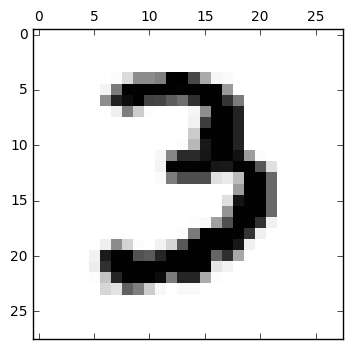

In [9]:
row = 10
num = my_data[row, :][0]
pic=my_data[row, :][1:].reshape(28,28)
print(num)
plt.matshow(pic, cmap='Greys')

In [10]:
def extract(row):
    num = row[0]
    pic = row[1:]
    return (num, pic)

def encode2vec(num):
    converted = int(num) % 10
    result = np.zeros((10,), dtype='int')
    result[converted] = 1
    return result

def normalize_pixel(pixels):
    return pixels/256

Y = np.ndarray((42000,1), dtype='int')
Y_t = np.ndarray((42000,10), dtype='int')
U = np.ndarray((42000,784))

for i in range(1,42001):
    num, pic = extract(my_data[i, :])
    Y[i-1, :] = num
    U[i-1, :] = normalize_pixel(pic)
    
X_train, X_test, y_train, y_test = train_test_split(U, Y, test_size=0.2, random_state=42, stratify=Y)
y_v_train = np.ndarray((y_train.shape[0], 10), dtype=int, buffer=np.array([encode2vec(y) for y in y_train]))
y_v_test = np.ndarray((y_test.shape[0], 10), dtype=int, buffer=np.array([encode2vec(y) for y in y_test]))

In [11]:
X_train.shape

(33600, 784)

In [12]:
y_v_train.shape

(33600, 10)

In [13]:
# load the data
trainLen = 2000
testLen = 2000
initLen = 0 # Practical ESN 4.5

# generate the ESN reservoir
sequenceLength=784
inSize = 1
outSize = 10
resSize = 1000
a = 0.1 # leaking rate

In [14]:
Win, W = build_reservoir()

In [17]:
# for i in range(0,10000):
#     data[i] = abs(math.sin(math.log(1+i**(0.5))))
# plt.plot(data[0:10000])

In [69]:
X_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [112]:
%%time
examples, sequenceLength = X_train.shape

#X = np.zeros((1+inSize+resSize,examples))
#X = np.zeros((examples, 1+resSize))

# set the corresponding target matrix directly
#Yt = data[None,initLen+1:trainLen+1] 


# run the reservoir with the data and collect X
bias = np.ones((1, examples))
# build reservoir for this example
x = np.zeros((resSize,examples))
for pic in range(sequenceLength):
    u = X_train[:, pic]
    x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((bias,u)) ) + np.dot( W, x ) )
    print(pic, end="\r")
X = np.vstack((bias,x))


CPU times: user 1h 41min 51s, sys: 12min 12s, total: 1h 54min 3s
Wall time: 51min 39s


784

In [ ]:
# OLD
# # Our time of interest is 784, when all pixels was read by reservoir 
# examples, sequenceLength = X_train.shape

# #X = np.zeros((1+inSize+resSize,examples))
# X = np.zeros((examples, 1+resSize))
# # set the corresponding target matrix directly
# #Yt = data[None,initLen+1:trainLen+1] 


# # run the reservoir with the data and collect X

# for e in range(examples):
#     picture = X_train[e]
#     # build reservoir for this example
#     x = np.zeros((resSize,1))
#     for pic in picture:
#         u = pic
#         x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
#     X[e,:] = np.vstack((1,x))[:,0]
#     print(e, end='\r')

# for t in range(trainLen):
#     u = data[t]
#     x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
#     if t >= initLen:
#         X[:,t-initLen] = np.vstack((1,u,x))[:,0]
        
# reg = 1e-1  # regularization coefficient
# X_T = X.T
# Wout = np.dot( np.dot(Yt,X_T), np.linalg.inv( np.dot(X,X_T) + \
#     reg*np.eye(1+inSize+resSize) ) ) 


# Y = np.zeros((outSize,testLen))
# u = data[trainLen]
# for t in range(testLen):
#     x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
# #     x = np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
#     y = np.dot( Wout, np.vstack((1,u,x)) )
#     Y[:,t] = y
#     # generative mode:
#     u = y
#     ## this would be a predictive mode:
#     #u = data[trainLen+t+1] 
    
# errorLen = 1000
# mse = np.sum( np.square( data[trainLen+1:trainLen+errorLen+1] - Y[0,0:errorLen] ) ) / errorLen
# print('MSE = ' + str( mse ))


# plt.figure(1).clear()
# plt.plot( data[trainLen+1:trainLen+testLen+1], 'g' )
# plt.plot( Y.T, 'b' )
# plt.title('Target and generated signals $y(n)$ starting at $n=0$')
# plt.legend(['Target signal', 'Free-running predicted signal'])


# plt.figure(2).clear()
# plt.plot( X[0:20,0:200].T )
# plt.title('Some reservoir activations $\mathbf{x}(n)$')

In [174]:
X_processed = X[0:5000, :]

In [117]:
reg = 1e-6  # regularization coefficient
X_T = X.T
Wout = np.dot( np.dot(y_v_train.T,X_T), np.linalg.inv( np.dot(X,X_T) + \
    reg*np.eye(1+resSize) ) ) 

(1001, 33600)

In [68]:
# OLD

# %%time
# # Our time of interest is 784, when all pixels was read by reservoir 
# examples, sequenceLength = X_test.shape


# # run the reservoir with the data and collect X
# predicts = []
# for e in range(examples):
#     picture = X_test[e]
#         # build reservoir for this example
#     x = np.zeros((resSize,1))
#     for pic in picture:
#         u = pic
#         x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
#     y = np.dot( Wout, np.vstack((1,x)) )
#     predicts.append(y)
#     print(e, end='\r')

# predict = np.array([np.argmax(predict) for predict in predicts])
# print('Accuracy ', metrics.accuracy_score(y_test, predict))
# print(metrics.classification_report(y_test, predict))

In [ ]:
%%time
x = np.zeros((resSize,examples))
bias = np.ones((1, examples))
for pix in range(X_test.shape[1]):
    u = X_test[:, pix]
    x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((bias,u)) ) + np.dot( W, x ) )
    print(pix, end="\r")
y = np.dot( Wout, np.vstack((bias,x)) )
predict = np.array(np.argmax(y, axis=0))

print(metrics.classification_report(y_test, predict))
print('Accuracy ', metrics.accuracy_score(y_test, predict))

In [260]:
%%file esn_classifier.py
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
import scipy.sparse as sparse

class EsnClassifier(BaseEstimator, ClassifierMixin):
    """Echo state network classifier"""
    def __init__(self, \
                 density=1, reservoirSize=100, outputleakingRate=1, \
                 inputSize=1, outputSize=1, leakingRate = 1, \
                 randomState=None, regularizationCoefficient=10e-6):
        """
        Called when initializing the classifier
        """
        self.density = 1
        self.reservoirSize = 100
        self.leakingRate = leakingRate
        self.randomState = randomState
        self.outputSize = outputSize
        self.inputSize = inputSize
        self.regularizationCoefficient = regularizationCoefficient
    
    def fit(self, X, y=None):
        """
        """
        # FIXME: add Asserts or try/catch
        
        examples, sequenceLength = X.shape
        self.Win_, self.W_ = self.build_reservoirs()
    
        bias = np.ones((1, examples))
        
        # run the reservoir with the data and collect X
        x = np.zeros((self.reservoirSize,examples))
        for pic in range(sequenceLength):
            u = X[:, pic]
            x = (1-self.leakingRate)*x + self.leakingRate*np.tanh( np.dot( self.Win_, np.vstack((bias,u)) ) + np.dot( self.W_, x ) )
            print(pic, end="\r")
        
        # Reservoir values
        X = np.vstack((bias,x))
        
        # Fit linear regression
        X_T = X.T
        self.Wout_ = np.dot( np.dot(y.T,X_T), np.linalg.inv( np.dot(X,X_T) + \
            self.regularizationCoefficient*np.eye(1+self.reservoirSize) ) ) 
        return self
    
    def predict(self, X, y=None):
        '''
        '''
        examples, sequenceLength = X.shape
        x = np.zeros((self.reservoirSize,examples))
        bias = np.ones((1, examples))
        for pix in range(sequenceLength):
            u = X[:, pix]
            x = (1-self.leakingRate)*x + self.leakingRate*np.tanh( np.dot( self.Win_, np.vstack((bias,u)) ) + np.dot( self.W_, x ) )
            print(pix, end="\r")
            
        y = np.dot( self.Wout_, np.vstack((bias,x)) ).T 
        return np.array(np.argmax(y, axis=1))
    
    
    # Helpers to build reservoir
    def __spectral_radius(self, matrix):
        '''
        Calculate spectral radius of matrix. 
        Spectral radius is max absolute eigenvalue.
        '''
        # FIXME: remove code below
        inner = matrix
        eigenvalues = np.linalg.eig(inner)[0]
        return max(abs(eigenvalues))
    
    def build_reservoirs(self):
        '''
        Generate reservoirs
        '''
        # FIXME: move to spartial
        
        # include bias term
        Win =  sparse.rand(self.reservoirSize, self.inputSize + 1, density=self.density, random_state=self.randomState)
        Win -= (Win.sign()*0.5)

        W = sparse.rand(self.reservoirSize, self.reservoirSize, density=self.density, random_state=self.randomState)
        W -= W.sign()*0.5
        W *= 1.25/self.__spectral_radius(W.toarray())
        return (Win.toarray(), W.toarray())

Overwriting esn_classifier.py


In [249]:
from esn_classifier import EsnClassifier
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [250]:
def extract(row):
    num = row[0]
    pic = row[1:]
    return (num, pic)

def encode2vec(num):
    converted = int(num) % 10
    result = np.zeros((10,), dtype='int')
    result[converted] = 1
    return result

def normalize_pixel(pixels):
    return pixels/256

Y = np.ndarray((8816,1), dtype='int')
Y_t = np.ndarray((8816,10), dtype='int')
U = np.ndarray((8816,784))
counter = 0
for i in range(1,42001):
    num, pic = extract(my_data[i, :])
    if int(num) not in [1,0]:
        continue
    Y[counter, :] = int(num)
    U[counter, :] = normalize_pixel(pic)
    counter +=1
    
X_train, X_test, y_train, y_test = train_test_split(U, Y, test_size=0.8, random_state=42)
y_v_train = np.ndarray((y_train.shape[0], 10), dtype=int, buffer=np.array([encode2vec(y) for y in y_train]))
y_v_test = np.ndarray((y_test.shape[0], 10), dtype=int, buffer=np.array([encode2vec(y) for y in y_test]))
counter

8816

In [251]:
clf = EsnClassifier(reservoirSize=1000, outputSize=10)

In [252]:
clf.fit(X_train[0:100,:], y_v_train[0:100, :])

EsnClassifier(density=1, inputSize=1, leakingRate=1, outputSize=10,
       outputleakingRate=None, randomState=None,
       regularizationCoefficient=1e-05, reservoirSize=100)

In [253]:
clf.predict(X_train[0:100, :])

array([0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [214]:
examples, sequenceLength = X_train[0:100, :].shape
x = np.zeros((clf.reservoirSize,examples))

In [256]:
# y_train[0:100, :]

array([[0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
    

In [259]:
# metrics.accuracy_score(y_train[0:100, :], np.ones((100,1)))

0.53000000000000003

In [232]:
self = clf
X = X_train[0:100, :]
y = y_v_train[0:100, :]

In [233]:
examples, sequenceLength = X.shape
self.Win_, self.W_ = self.build_reservoirs()

bias = np.ones((1, examples))

# run the reservoir with the data and collect X
x = np.zeros((self.reservoirSize,examples))
for pic in range(sequenceLength):
    u = X[:, pic]
    x = (1-self.leakingRate)*x + self.leakingRate*np.tanh( np.dot( self.Win_, np.vstack((bias,u)) ) + np.dot( self.W_, x ) )
    print(pic, end="\r")

# Reservoir values
X = np.vstack((bias,x))

# Fit linear regression
X_T = X.T

In [234]:
Wout_ = np.dot( np.dot(y.T,X_T), np.linalg.inv( np.dot(X,X_T) + \
            self.regularizationCoefficient*np.eye(1+self.reservoirSize) ) ) 

In [237]:
Wout_.shape

(10, 101)

In [226]:
y_v_train

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ..., 
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [240]:
# np.dot( self.Wout_, np.vstack((bias,x)) ).T

array([[  95.04214842,  -94.8967609 ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [ 108.89630518, -108.75223612,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [ 104.17599362, -104.02787832,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [ 114.59396403, -114.45055712,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [ 110.03177783, -109.88931505,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [ 123.75233087, -123.61126219,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0

In [263]:
{}.values()

dict_values([])